# 3. Unsupervised Analysis

Once medieval texts are converted to a numerical format, the ensuing ways to manipulate and analyse them are numerous. In general, two general approaches can be discerned, parallel to a classic data-scientific distinction, (a) non-supervised and (b) supervised. The latter will be subject of our next notebook.

Unsupervised methods allow to inspect data and enable a detection of trends on an **exploratory** basis. As opposed to supervised learning, it needs no labelled training input in order to be operational. Its aim is to describe without prescience, not to classify. By implication, the general disadvantage of unsupervised methods is that there is limited possibility of evaluation (a degree-of-error) for each observation, nor can it give estimations of which features are redundant for certain questions. Therefore, practitioners strongly advise to back up unsupervised analysis with supervised evidence when that proves feasible.

Examples of unsupervised techniques applied to medieval texts are numerous. Popularly used are **principal components analysis** or **PCA** (Kestemont et al. 2015), ***k* nearest neighbours** (sometimes visualized with network analysis; e.g. Eder 2016:72), **t-distributed stochastic neighbor embedding** or t-SNE (Leclercq and Kestemont 2021:229) and **dendrogram analysis** (e.g. Dockray-Miller et al. 2021).

Before we proceed, we **repeat**, with the block of code below, **the steps from the previous notebook.**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Petrus-Abaelardus_Commentariorum-super-S-Pauli-Epistolam-ad-Romanos_cleaned.txt to Petrus-Abaelardus_Commentariorum-super-S-Pauli-Epistolam-ad-Romanos_cleaned.txt
Saving Bernardus-Claraevallensis_Sermones-super-cantica-canticorum_cleaned.txt to Bernardus-Claraevallensis_Sermones-super-cantica-canticorum_cleaned.txt
Saving Hildegardis-Bingensis_Liber-divinorum-operum_cleaned.txt to Hildegardis-Bingensis_Liber-divinorum-operum_cleaned.txt


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from string import punctuation
import numpy as np
import pandas as pd
import re

# Lists to store metadata and text segments
authors = []
titles = []
texts = []

sample_len = 1500  # Number of words per segment

# Process all uploaded files
for filename in uploaded.keys():
    author = filename.split("/")[-1].split(".")[0].split("_")[0]
    title = filename.split("/")[-1].split(".")[0].split("_")[1]

    bulk = []
    text = open(filename, encoding='utf-8-sig').read()  # Read file and handle BOM

    # Clean text: remove digits, punctuation, lowercase
    for word in text.strip().split():
        word = re.sub(r'[\d%s]', '', word)
        word = re.sub('[%s]' % re.escape(punctuation), '', word)
        word = word.lower()
        bulk.append(word)

    bulk = [word for word in bulk if word != ""]  # Remove empty strings
    bulk = [bulk[i:i+sample_len] for i in range(0, len(bulk), sample_len)]  # Split into segments

    # Keep only full-length segments
    for index, sample in enumerate(bulk):
        if len(sample) == sample_len:
            authors.append(author)
            titles.append(f"{title}_{index+1}")
            texts.append(" ".join(sample))

# Vectorize text by most frequent words
model = CountVectorizer(max_features=250, analyzer='word', ngram_range=(1,1))
X = model.fit_transform(texts).toarray()

# Sort features by frequency
feat_frequencies = np.asarray(X.sum(axis=0)).flatten()
features = model.get_feature_names_out()
feat_freq_df = pd.DataFrame({'feature': features, 'frequency': feat_frequencies})
feat_freq_df = feat_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
sorted_features = feat_freq_df['feature'].tolist()

# Refit vectorizer with sorted vocabulary
model = CountVectorizer(analyzer='word', vocabulary=sorted_features, ngram_range=(1,1))
X = model.fit_transform(texts).toarray()

# Scale features for uniform variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 3.1 Principal Components Analysis (PCA)

Principal Components Analysis (**PCA**) is a commonly and popularly applied technique to reproject high-dimensional data in an informative and visualizable lower dimensional space. It maximally captures the features’ variance **in 2 or 3 "principal components" (PC’s)** or **"composite features"**. Although PC’s do not capture the full lexical information available in the data, they summarize it by its most informative trends and weed out redundant features (i.e. features with a low variance). The first component explains the largest proportion of the variance in the data set. The second component is orthogonal to the first and explains the largest proportion of the remaining variance. The third component is orthogonal to the second, and this pattern continues with each subsequent component (also see Craig, "Principal Components Analysis", 2024).

PCA centers the features’ frequencies, where the mean shifts to zero, and where frequencies are recast to their number of standard deviations removed from the mean (this is how the x-, y- and z-axis, respectively PC 1, PC 2, and PC 3, should thus be read in the figure you will learn to plot below). The data point, i.e. a text segment, is apportioned a position in space by coordinates that correspond to its distance (i.e. number of standard deviations) away from the means of PC’s 1 and 2. Put differently, the higher the absolute coordinate values of the data points, the further they are removed from the intersection point (0,0), and the "more deviant" their lexical composition is in terms of the predefined features — i.e. outliers.

Also here, Scikit-Learn provides us with a helpful module: `sklearn.decomposition.PCA`.

The original variables’ contribution to the principal components is indicated by `loadings` (variables `l1, l2, l3` below), i.e. weights for each PC, and normalized to `[-1, 1]`. They are plotted on top of scatterplot. Higher absolute loadings indicate higher importance in explaining the variability of the original data.

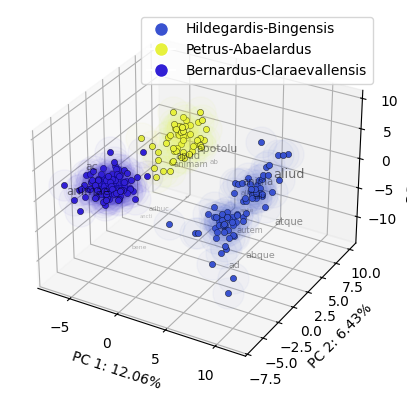

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random&

# -------------------------------------------------------
# PCA: reduce features to 3 principal components
# -------------------------------------------------------
pca = PCA(n_components=3)
X_bar = pca.fit_transform(X)

# Explained variance per PC
var_exp = pca.explained_variance_ratio_
var_pc1, var_pc2, var_pc3 = np.round(var_exp[:3]*100, 2)

# PCA loadings (feature contributions)
loadings = pca.components_.T

# Sort features by contribution per PC
vocab_weights_p1 = sorted(zip(features, loadings[:,0]), key=lambda t: t[1], reverse=True)
vocab_weights_p2 = sorted(zip(features, loadings[:,1]), key=lambda t: t[1], reverse=True)
vocab_weights_p3 = sorted(zip(features, loadings[:,2]), key=lambda t: t[1], reverse=True)

# -------------------------------------------------------
# 3D scatterplot setup
# -------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x1, x2, x3 = X_bar[:,0], X_bar[:,1], X_bar[:,2]

# Rescale loadings to plot range
scaler_one = MinMaxScaler(feature_range=(min(x1), max(x1)))
scaler_two = MinMaxScaler(feature_range=(min(x2), max(x2)))
scaler_three = MinMaxScaler(feature_range=(min(x3), max(x3)))

realigned_l1 = scaler_one.fit_transform(loadings[:,0].reshape(-1,1)).flatten()
realigned_l2 = scaler_two.fit_transform(loadings[:,1].reshape(-1,1)).flatten()
realigned_l3 = scaler_three.fit_transform(loadings[:,2].reshape(-1,1)).flatten()

# Normalize loadings for opacity
normalized_l1 = (np.abs(loadings[:,0]) - min(np.abs(loadings[:,0]))) / (max(np.abs(loadings[:,0])) - min(np.abs(loadings[:,0])))
normalized_l2 = (np.abs(loadings[:,1]) - min(np.abs(loadings[:,1]))) / (max(np.abs(loadings[:,1])) - min(np.abs(loadings[:,1])))
normalized_l3 = (np.abs(loadings[:,2]) - min(np.abs(loadings[:,2]))) / (max(np.abs(loadings[:,2])) - min(np.abs(loadings[:,2])))

# Compute feature ranks per PC, weighted by explained variance
d = {feat: [] for feat, _ in zip(features, normalized_l1)}
for idx, (feat, _) in enumerate(zip(features, normalized_l1)):
    d[feat].append(idx * var_pc1)
for idx, (feat, _) in enumerate(zip(features, normalized_l2)):
    d[feat].append(idx * var_pc2)
for idx, (feat, _) in enumerate(zip(features, normalized_l3)):
    d[feat].append(idx * var_pc3)

# Select top discriminating features
n_top_discriminants = 20
best_discriminants = sorted([[feat, np.average(ranks)] for feat, ranks in d.items()], key=lambda x: x[1])
top_discriminants = [i[0] for i in best_discriminants][:n_top_discriminants]

# -------------------------------------------------------
# Assign random color per author
# -------------------------------------------------------
def generate_random_color():
    return [random.random() for _ in range(3)]

color_dict = {author: generate_random_color() for author in set(authors)}

# Plot data points
for p1, p2, p3, a, title in zip(x1, x2, x3, authors, titles):
    color = color_dict[a]
    ax.scatter(p1, p2, p3, marker='o', color=color, s=20, zorder=3, alpha=1, edgecolors='k', linewidth=0.3)
    ax.scatter(p1, p2, p3, marker='o', color=color, s=500, zorder=1, alpha=0.03)  # light "cloud" background

# Plot top features with opacity scaled by importance
for x, y, z, opac_l1, opac_l2, opac_l3, feat in zip(realigned_l1, realigned_l2, realigned_l3, normalized_l1, normalized_l2, normalized_l3, features):
    total_opac = (opac_l1 + opac_l2 + opac_l3)/3
    if feat in top_discriminants:
        ax.text(x, y, z, feat, color='k', ha='center', va='center', fontdict={'size': 17*total_opac}, zorder=10000, alpha=total_opac)

# Axes labels with explained variance
ax.set_xlabel(f'PC 1: {var_pc1}%')
ax.set_ylabel(f'PC 2: {var_pc2}%')
ax.set_zlabel(f'PC 3: {var_pc3}%')

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=author)
           for author, color in color_dict.items()]
ax.legend(handles=handles)

plt.show()


## 3.2 Dendrogram Analysis

Hierarchical clustering, also known as “agglomerative clustering”.

The code and explanation below is cited from *Humanities Data Analysis: Case Studies with Python*, which "gives a practical guide to data-intensive humanities research using the Python programming language." The book is written by Folgert Karsdorp, Mike Kestemont and Allen Riddell, and is available as an Open Access interactive Jupyter Book here: https://www.humanitiesdataanalysis.org/stylometry/notebook.html .

"*This clustering method works bottom-up: it will first detect very low-level text clusters that are highly similar. These texts are then joined into clusters that eventually are merged with other clusters that have been detected. Such a model is often visualized using a tree-like graph or “dendrogram” (an example will be offered shortly), showing at which stages subsequent clusters have been merged in the procedure. As such, it offers an efficient visualization from which the main structure in a dataset becomes clear at a glance. Because of the tree-with-branches metaphor, this model is strongly hierarchical in nature.*" (M. Kestemont, [link](https://www.humanitiesdataanalysis.org/stylometry/notebook.html))

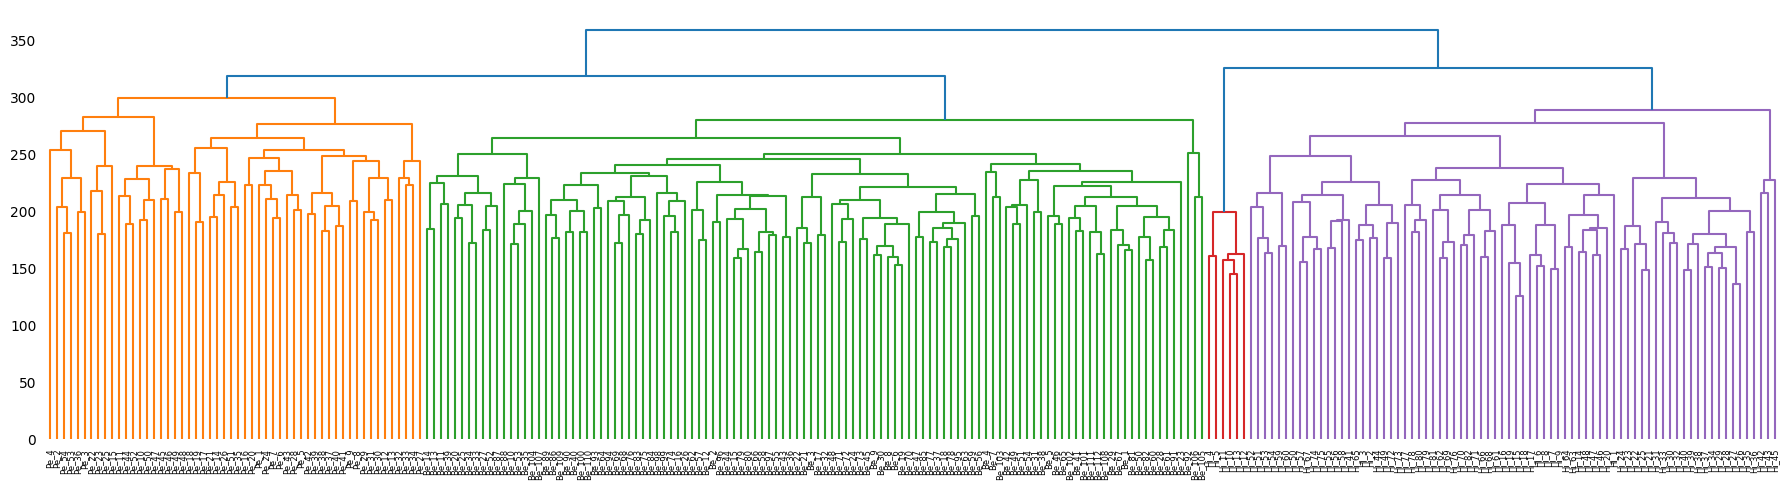

In [10]:
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from matplotlib import rcParams
from matplotlib import font_manager

author_labels = []
for author, title in zip(authors, titles):
    first_part = author[:2]
    second_part = title.split('_')[-1]
    label = first_part + '_' + second_part
    author_labels.append(label)

expected_classes = 4  # adjust to get the dendrogram color threshold right

# 1. Calculate pairwise distances
dm = pdist(X, 'cityblock')

# 2. Establish branch structure
linkage_matrix = linkage(dm, method='complete', optimal_ordering=True)

def plot_tree(linkage_matrix, labels, expected_classes=2, figsize=(18, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Get merge distances (ascending)
    distances = np.sort(linkage_matrix[:, 2])

    # Determine threshold to produce exactly `expected_classes` clusters:
    # cut just BELOW the (k-1)-th largest merge height.
    if expected_classes is None or expected_classes <= 1:
        # Monochrome: everything "above" threshold color (single color)
        color_threshold = 0.0
    else:
        # Number of merges equals n_samples - 1; guard against out-of-range k
        n_merges = len(distances)
        if expected_classes - 1 >= n_merges:
            # Too many clusters requested; fall back to monochrome
            color_threshold = 0.0
        else:
            # heights[-1] = largest, heights[-(k-1)] = (k-1)-th largest
            # subtract a tiny epsilon to be strictly below that height
            color_threshold = distances[-(expected_classes - 1)] - 1e-12

    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        ax=ax,
        leaf_font_size=6,
        leaf_rotation=90,
        color_threshold=color_threshold,
        # Reuse an existing cluster color for above-threshold links so we don't add a 5th distinct color:
        above_threshold_color='C0',
    )

    # Clean up look
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

    plt.tight_layout()
    plt.show()

plot_tree(linkage_matrix, labels=author_labels, expected_classes=expected_classes)


"*The tree should be read from bottom to top, where the original texts are displayed as the tree’s leaf nodes. When moving to the top, we see how these original nodes are progressively being merged in new nodes by vertical branches. Subsequently, these newly created, non-original nodes are eventually joined into higher-level nodes and this process continues until all nodes have been merged into a single root node at the top. On the vertical axis, we see numbers which we can read as the distance between the various nodes: the longer the branches that lead up to a node, the more distant the nodes that are being merged.*" (M. Kestemont, [link](https://www.humanitiesdataanalysis.org/stylometry/notebook.html))

## 3.3 T-SNE

**T-SNE**, or t-distributed stochastic neighbor embedding, (Van der Maaten and Hinton, 2008), is a machine learning algorithm for non-linear dimensionality reduction, particularly well-suited for visualizing high-dimensional datasets.

Say we have a pair of vectors, representing respectively text segment A and text segment B.

1. Firstly, t-SNE looks at how likely segment A is to be a neighbor of segment B in its **input space**, as we know by now, often a **high-dimensional space**: calculating the probability that two segments are neighbors is what is called a **joint probability**. Note that it is highly recommended to first use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the input dimensions to a reasonable number (e.g. 50) if that number is very high.
2. Consequently, t-SNE defines another set of probabilities for an **embedding space** or **lower-dimensional space**, often 2 or 3 dimensions.
3. Taking both sets of probabilities into account, t-SNE's main objective is to ensure that the lower-dimensional embedding **preserves** the pairwise relationships (joint probabilities) and complexities of the original or higher-dimensional data. It does so by minimizing the so-called Kullback-Leibler (KL) divergence between both sets of probabilities.  

As step 3 suggests, and as opposed to PCA, t-SNE has a (at times costly) learning process, with a number of **sensitive parameters** which heavily influence the resulting diagrammatic representation. In a way, the algorithm is 'smarter' than PCA, but also comes with configurable hyperparameters such as the **(1) perplexity**, **(2) learning rate**, and the **(3) number of iterations**, which need to be well understood.

1. Perplexity (`perp`) controls the trade-off between capturing both the local and global aspects of the corpus. Smaller `perp`-values focus more on capturing the local structure (more clusters), while larger values will take a broader view (fewer clusters). Typically, the values range between 5 and 50.
2. The learning rate (`lr`) controls the step size at each iteration: i.e. how much the algorithm should change the positions of the points per iteration. If it is too high, the data may become too spread out, and if it is too low, the data may become too compressed. Both situations can lead to poor representations. A common heuristic is to start with a learning rate between 10 and 1000.
3. Number of Iterations (`n_iter`): number of times the algorithm updates the positions of the data points.

In summary, t-SNE is a powerful tool for reducing high-dimensional data to lower dimensions for visualization, but its effectiveness can be influenced significantly by the choice of hyperparameters. Perplexity, learning rate, and the number of iterations are crucial parameters that control the algorithm's behavior and the quality of the final embedding. Adjusting these parameters through experimentation and cross-validation is often necessary to obtain the best results for a given dataset.

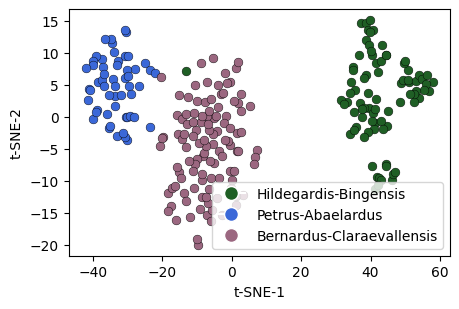

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

"""
Dimensionality reduction workflow using PCA + t-SNE.

1. PCA reduces very high-dimensional input to ~50 dims.
   - Speeds up t-SNE optimization
   - Denoises and removes collinearity
2. t-SNE maps reduced data into 2D while preserving local/global structure.
   - Key hyperparameters:
     - perplexity: trade-off local vs. global structure (5–50 common)
     - learning_rate: step size in optimization
     - max_iter: number of optimization iterations
3. Visualization: points are colored per author with legend.
"""

# --- Parameters ---
lr = 10           # learning rate for t-SNE optimization
max_iter = 1000   # maximum number of iterations
perp = 10         # low perplexity = local | high perplexity = global structure

# --- Step 1: Reduce dimensionality with PCA before t-SNE ---
# PCA condenses features into 50 principal components
pca = PCA(n_components=50)
pca_X = pca.fit_transform(X)

# --- Step 2: Compute t-SNE embedding ---
# Maps PCA-reduced data into 2D
tsne = TSNE(
    n_components=2,       # project into 2D for visualization
    perplexity=perp,      # balance local vs. global structure
    learning_rate=lr,     # optimization step size
    max_iter=max_iter     # iterations for convergence
)
tsne_X = tsne.fit_transform(pca_X)

# --- Step 3: Plotting ---
# Create 2D scatter of t-SNE projection
fig = plt.figure(figsize=(4.7, 3.2))
ax = fig.add_subplot(111)
x1, x2 = tsne_X[:, 0], tsne_X[:, 1]

# -------------------------------------------------------
# Assign random color per author
# -------------------------------------------------------
def generate_random_color():
    """Generate a random RGB color as a list of floats."""
    return [random.random() for _ in range(3)]

color_dict = {author: generate_random_color() for author in set(authors)}

# Scatter each point, colored by author, with black edge
for p1, p2, a in zip(x1, x2, authors):
    ax.scatter(
        p1, p2,
        marker='o',
        color=color_dict[a],  # color based on author
        s=40,                 # marker size
        edgecolors='k',       # black border around marker
        linewidths=0.3
    )

# Label axes
ax.set_xlabel('t-SNE-1')
ax.set_ylabel('t-SNE-2')

# --- Step 4: Create legend ---
# Each author gets a marker in the legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color, markersize=10, label=author)
    for author, color in color_dict.items()
]
ax.legend(handles=handles)

plt.tight_layout()
plt.show()